# **Creating a Convolutional Neural Network for image classification with PyTorch**

Author: Javier Eguíluz Romero

This notebook contains the code to create and train a convolutional neural network that reads and classifies images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). Prior to the data loading and training there're some definitions of functions that will help with the processes.

I have added some interesting stuff: the data is normalized, the training can be done in parallel and it is possible to visualize the preformance for every class.



## Libraries and Settings

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import Adam, SGD
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Function definitions

### Definition of the Neural Network

In [20]:
# Architecture of the CNN.

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3,6,5) # The input is 3 because of the images are in 3-color base.
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # Cheat note for output in a convolutional layer: (INPUT-FILTER + 2*PADDING)/STRIDE+1
    # Output (32-5+2*0)/1+1=28 then 28x28
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(-1, 16*5*5) # Flatten the tensor to feed the output to the linear layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

### Helper Functions

In [ ]:
# Loads the data from the MNIST dataset and prepares it in batches of size "batch_size". If "train_bool" is true, it retrieves the training data, otherwise it gets the testing data.
def LoadData(batch_size, transform, train_bool=True):
  data = DataLoader(
      datasets.CIFAR10(root='dataset/', train=train_bool, transform=transform, download=True),
      batch_size=batch_size, 
      shuffle=train_bool)    
  return data

In [ ]:
# Trains the NN taking the training data through as many epochs as defined. The backward method can be changed.
def train(data_train, model, criterion, optimizer, epochs):
  for epoch in tqdm(range(epochs)):
    for data, targets in data_train:
      data = data.to(device)
      targets = targets.to(device)

      # forward
      scores = model(data)
      loss = criterion(scores, targets)

      #backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

In [ ]:
# Provides with the performance of the model via the parameters: Precision, Recall and the F1 score for each one of the classes.
def performance_metrics(model, dataset):
  true_positives = [0]*10
  false_negatives = [0]*10
  false_positives = [0]*10

  model.eval()
  with torch.no_grad():
    for data, targets in dataset:
      data = data.to(device)
      targets = targets.to(device)

      scores = model(data)
      _, predicted = scores.max(1)

      for i in range(targets.size()[0]):
        actual_value = targets[i]
        predicted_value = predicted[i]

        if predicted_value == actual_value:
          true_positives[actual_value] += 1
        else:
          false_negatives[actual_value] += 1
          false_positives[predicted_value] += 1

  model.train()

  #precision
  precision = np.divide( true_positives, np.add(true_positives,false_positives) )
  #recall
  recall = np.divide( true_positives, np.add(true_positives,false_negatives) )
  #F1 Score
  F1_score = 2*np.divide( np.multiply(precision,recall), np.add(precision,recall) )

  return precision, recall, F1_score

## Training and evaluation of the Neural Network

In [ ]:
# Definition of parameters.
learning_rate = 0.001
epochs = 5
batch_size = 4

### Loading the data from the CIFAR-10 Dataset

In [22]:
# Load the data.

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalization of the data

train_data = LoadData(batch_size, transform, train_bool=True)
test_data = LoadData(batch_size, transform, train_bool=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Training of the model

In [21]:
# Define the model

model = CNN()
if torch.cuda.device_count() > 1:
  print("There are ", torch.cuda.device_count(), "GPUs available to work.")
  model = nn.DataParallel(model)  # This allows us to train the model parallely if there is more than one GPU.

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)

In [23]:
train(train_data, model, criterion, optimizer, epochs)

100%|██████████| 5/5 [02:45<00:00, 33.17s/it]


### Testing of the model

In [24]:
# Get the performance

precision, recall, F1_score = performance_metrics(model,test_data)
print(f'The performance of the model on the test data gives these averaged values: Precision: {np.mean(precision)*100:.2f}%, Recall: {np.mean(recall)*100:.2f}%, F1 score: {np.mean(F1_score):.4f}.')

The performance of the model on the test data gives these averaged values: Precision: 44.09%, Recall: 43.84%, F1 score: 0.4159.


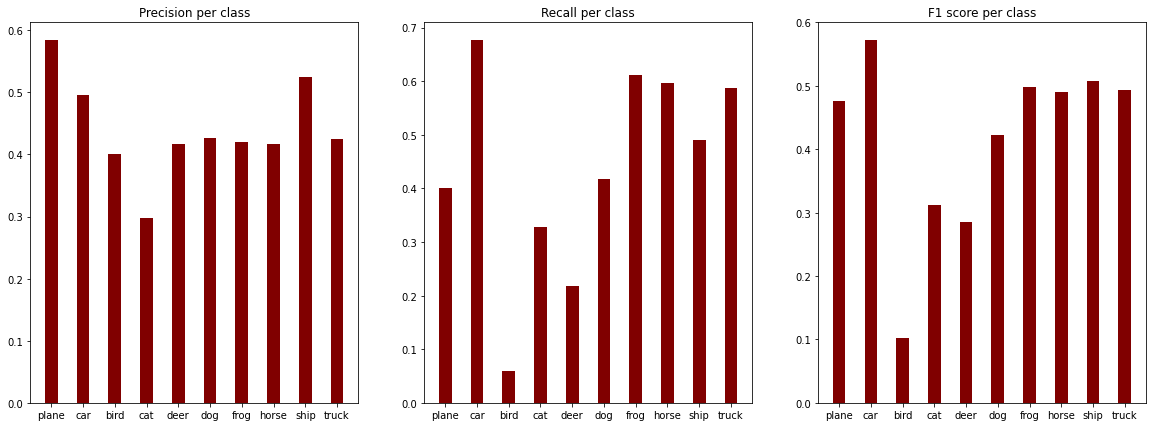

In [25]:
#Plot of the performance per class

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
 
# creating the bar plots
ax1.bar(classes, precision, color ='maroon', width = 0.4)
ax1.set_title("Precision per class")

ax2.bar(classes, recall, color ='maroon', width = 0.4)
ax2.set_title("Recall per class")

ax3.bar(classes, F1_score, color ='maroon', width = 0.4)
ax3.set_title("F1 score per class")

plt.show()

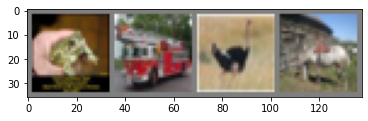

<Figure size 6400x5520 with 0 Axes>

frog  truck bird  horse


In [ ]:
# Display a random batch as prediction example

# function to unnormalize and show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_data)
images, labels = dataiter.next()

# show images
imshow(make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))